## Loading basic Dependencies

In [1]:
#loading basic dependencies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

import warnings
warnings.filterwarnings('ignore')

## Loading Data

In [2]:
#loading the data
data = pd.read_csv('Customers_in_a_Shop.csv',header=None)
data.columns = ['Date','Customers']
data['Date'] = pd.to_datetime(data['Date'],format="%Y-%m")
data = data.set_index('Date')

#shape of the data
data.shape

(144, 1)

## Missing Values

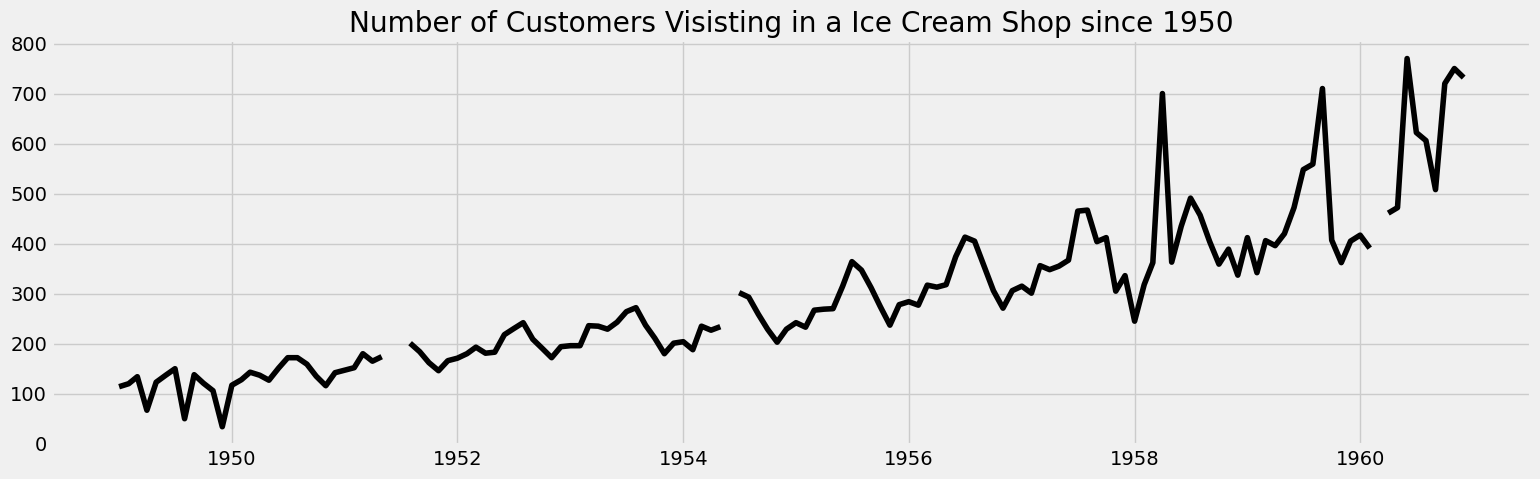

In [3]:
plt.rcParams['figure.figsize']=(17,5)
plt.plot(data,color='black')
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

## Linear Interpolation

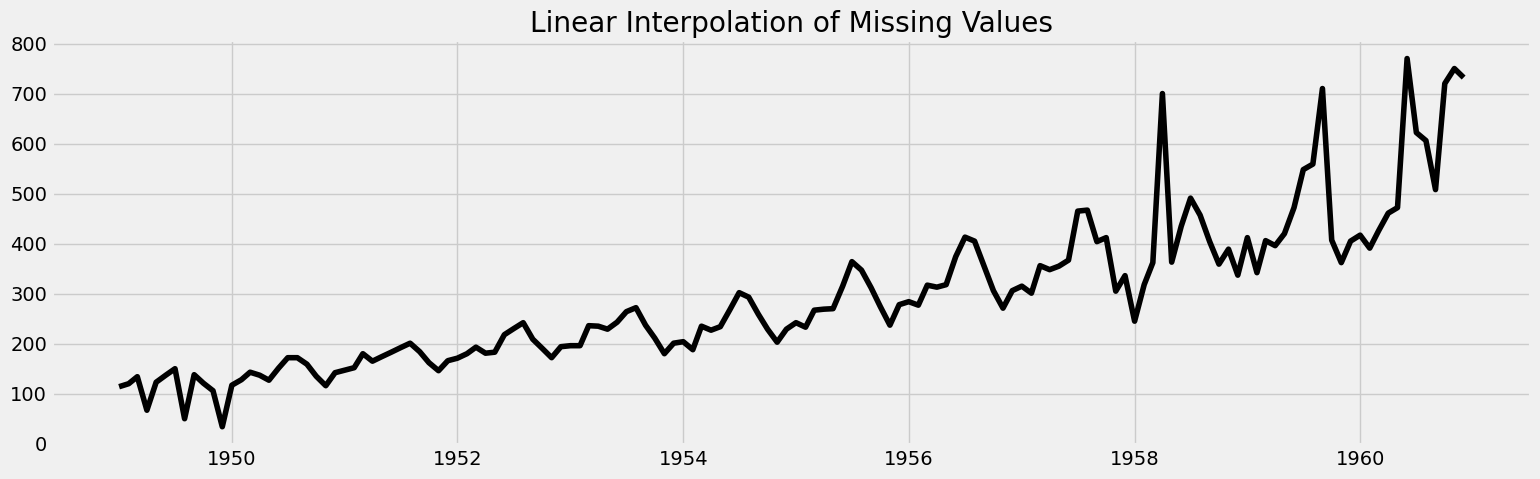

In [4]:
plt.rcParams['figure.figsize']=(17,5)
data['Customers_linear']=data['Customers'].interpolate(method='linear')
plt.plot(data['Customers_linear'],color='black')
plt.title("Linear Interpolation of Missing Values")
plt.show()

## Outlier Treatment

In [5]:
# outliers treatment

data['Customers_linear'].loc[(data['Customers_linear']>=700)] = 622

# Non-Stationary to Stationary Series

## Box Cox Transformation

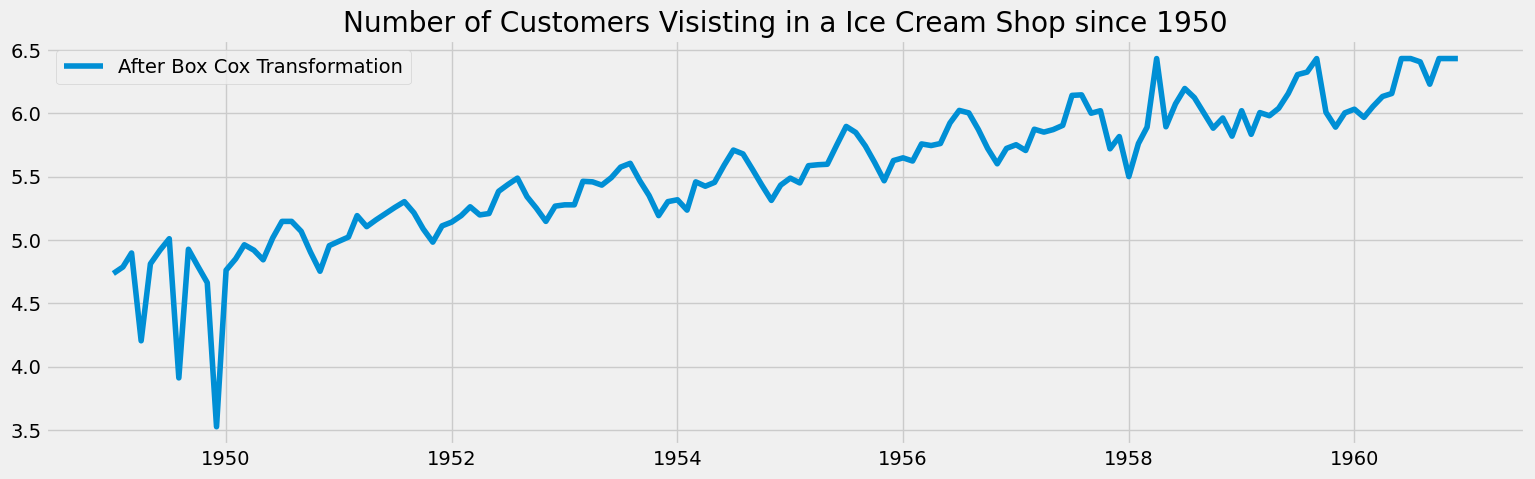

In [6]:
from scipy.stats import boxcox
data_boxcox = pd.Series(boxcox(data['Customers_linear'],lmbda=0),index=data.index)
plt.plot(data_boxcox, label="After Box Cox Transformation")
plt.legend()
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

## Differencing

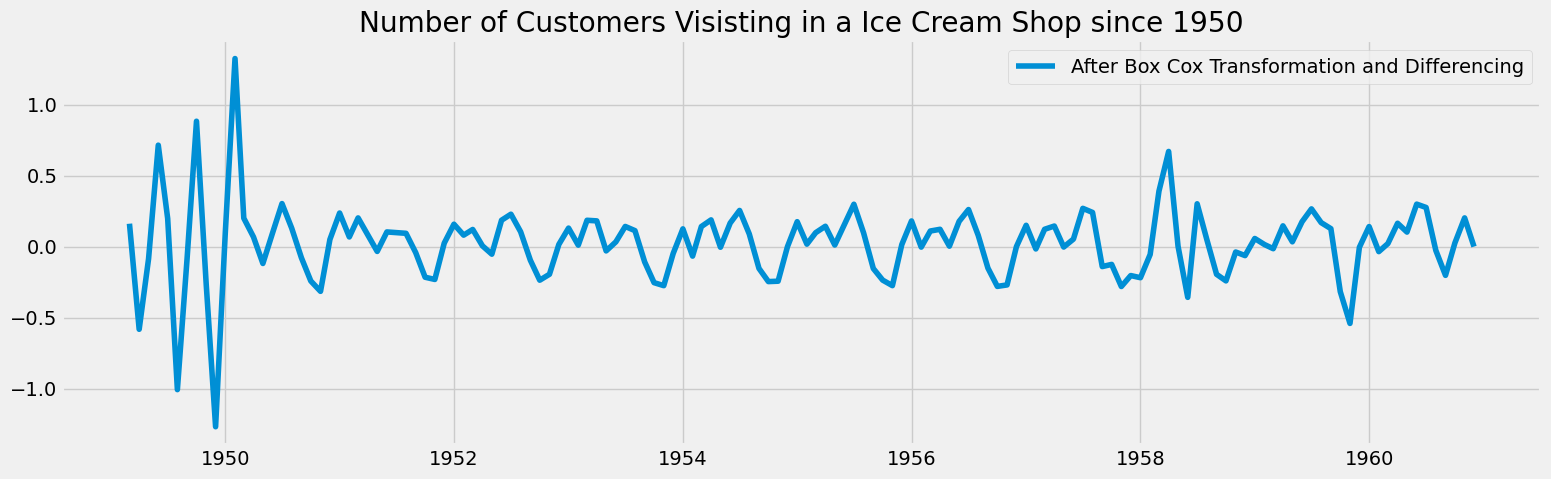

In [7]:
data_boxcox_difference= pd.Series(data_boxcox-data_boxcox.shift(periods=2), index=data.index)
data_boxcox_difference.dropna(inplace=True)
plt.plot(data_boxcox_difference, label="After Box Cox Transformation and Differencing")
plt.legend()
plt.title("Number of Customers Visisting in a Ice Cream Shop since 1950")
plt.show()

# Checking for Stationarity after Conversion

## ADF Test

In [8]:
from statsmodels.tsa.stattools import adfuller

result = adfuller(data_boxcox_difference, autolag='AIC')
print(f'ADF Statistic: {result[0]}')
print(f'n_lags: {result[1]:.20f}')
print(f'p-value: {result[1]:.20f}')
for key, value in result[4].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

ADF Statistic: -11.681920582270816
n_lags: 0.00000000000000000000
p-value: 0.00000000000000000000
Critial Values:
   1%, -3.4808880719210005
Critial Values:
   5%, -2.8836966192225284
Critial Values:
   10%, -2.5785857598714417


## KPSS Test

In [9]:
from statsmodels.tsa.stattools import kpss
result = kpss(data_boxcox_difference)
print(f'KPSS Statistic: {result[0]}')
print(f'p-value: {result[1]}')
print(f'num lags: {result[2]}')
print('Critial Values:')
for key, value in result[3].items():
    print('Critial Values:')
    print(f'   {key}, {value}')

KPSS Statistic: 0.12457037279065448
p-value: 0.1
num lags: 42
Critial Values:
Critial Values:
   10%, 0.347
Critial Values:
   5%, 0.463
Critial Values:
   2.5%, 0.574
Critial Values:
   1%, 0.739


D:\Fall 2022\490\venv\lib\site-packages\statsmodels\tsa\stattools.py:2022: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  warnings.warn(


# Autocorrelation function

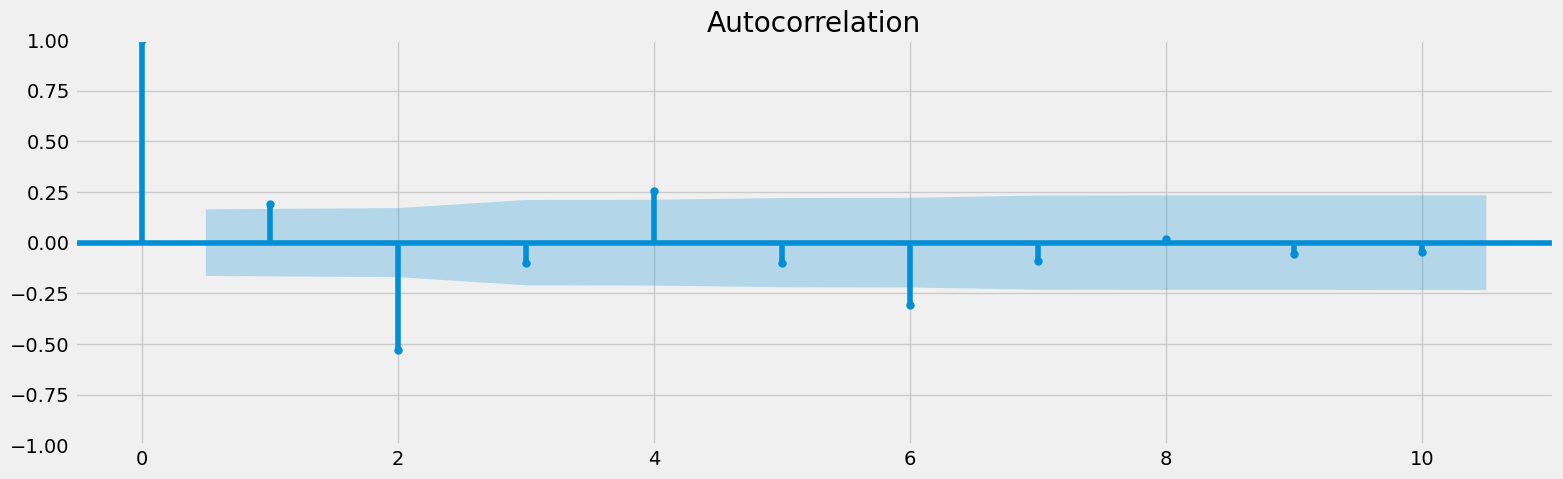

In [10]:
#Loading and plotting acf
from statsmodels.graphics.tsaplots import plot_acf
plot_acf(data_boxcox_difference, ax=plt.gca(), lags=10)
plt.show()

# Partial Correlation function

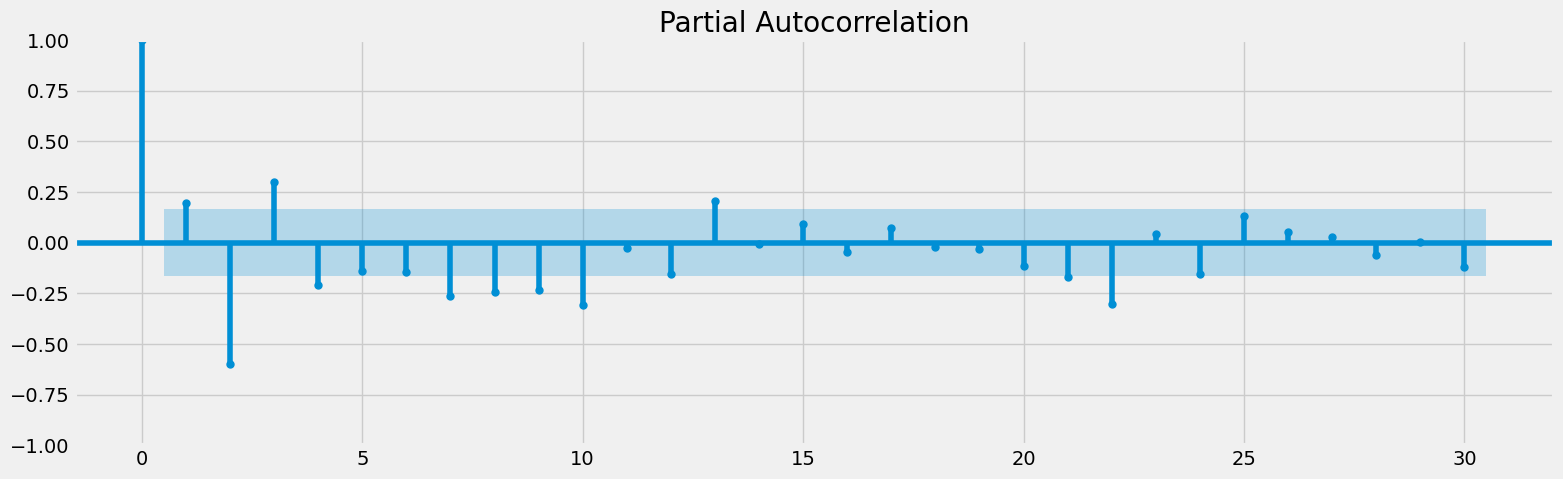

In [11]:
#Loading and plottin pacf
from statsmodels.graphics.tsaplots import plot_pacf
plot_pacf(data_boxcox_difference, ax=plt.gca(), lags=30)
plt.show()

# Splitting the dataset

In [12]:
length_train = 115
train = data.iloc[:length_train,:]
test=data.iloc[length_train:,: ]

train_data_boxcox = data_boxcox[:length_train]
test_data_boxcox = data_boxcox[length_train:]
train_data_boxcox_difference = data_boxcox_difference[:length_train-1]
test_data_boxcox_difference = data_boxcox_difference[length_train-1:]

# Auto Regressive Moving Average Model (ARMA)
ARMA Model combines both AR and MA model.

It takes into account one or more past observations as well as the past errors.

The ARMA model contains two parameters p and q

p is the highest lag in the time series

q is the number of past errors included
  

In [13]:
from statsmodels.tsa.arima.model import ARIMA

model_arma = ARIMA(train_data_boxcox_difference, order=(1,0,5))
model_fit = model_arma.fit()
print(model_fit.params) # Not important so can print or not

D:\Fall 2022\490\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Fall 2022\490\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
D:\Fall 2022\490\venv\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


const     0.025726
ar.L1     0.747600
ma.L1    -0.318460
ma.L2    -1.163371
ma.L3    -0.145705
ma.L4     0.488652
ma.L5     0.236097
sigma2    0.037577
dtype: float64


D:\Fall 2022\490\venv\lib\site-packages\statsmodels\base\model.py:604: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


# Recover Original Time Series Data

In [14]:
y_arma_new = data_boxcox_difference.copy()
y_arma_new['arma_forecast_boxcox_difference'] = model_fit.predict(data_boxcox_difference.index.min(),
                                                                  data_boxcox_difference.index.max())
y_arma_new['arma_forecast_boxcox'] = y_arma_new['arma_forecast_boxcox_difference'].cumsum()
y_arma_new['arma_forecast_boxcox'] = y_arma_new['arma_forecast_boxcox'].add(data_boxcox[0])
y_arma_new['arma_forecast'] = np.exp(y_arma_new['arma_forecast_boxcox'])

# Plotting Train, Test and Forecast

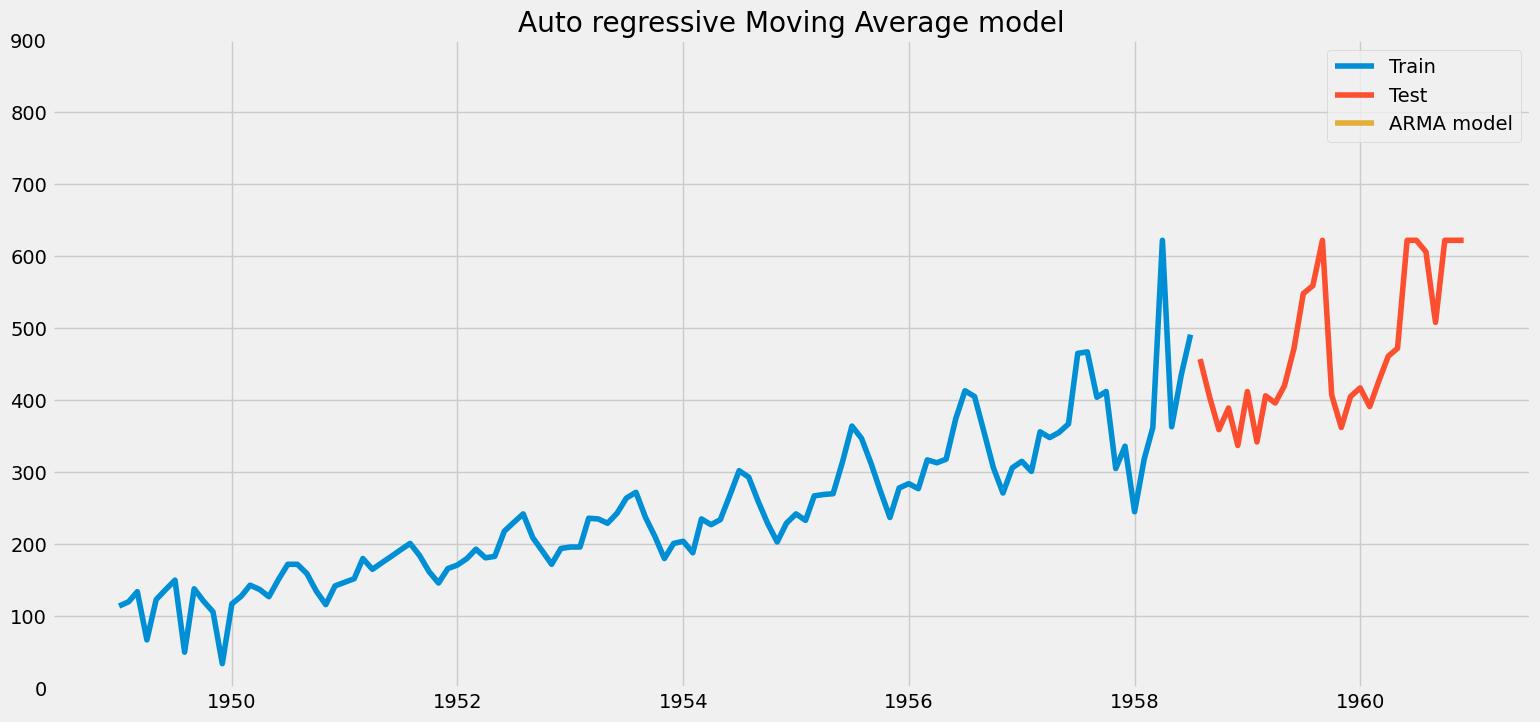

In [16]:
plt.figure(figsize=(17,8))

plt.plot(train['Customers_linear'], label = 'Train')
plt.plot(test['Customers_linear'], label = 'Test')
plt.plot(y_arma_new['arma_forecast'][test.index.min():], label = 'ARMA model')

plt.legend()
plt.title('Auto regressive Moving Average model')
plt.ylim(0, 900)
plt.show()